In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support

RANDOM_STATE = 42
np.random.seed(seed=RANDOM_STATE)


# To plot pretty figures
%matplotlib inline

# Credit Card Dataset

In [12]:
data_train = pd.read_csv("data/credit_train.csv", index_col=0)
data_test = pd.read_csv("data/credit_test.csv", index_col=0)

X_train = data_train.drop(data_train.columns[-1],axis=1)
y_train = data_train.iloc[:,-1]

X_test = data_test.drop(data_test.columns[-1],axis=1)
y_test = data_test.iloc[:,-1]
data_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,1.411588,0.993379,-0.456037,-0.894052,-0.467284,1.089217,3.024383,-1.194852,0.957057,1.281376,...,0.103171,0.409563,0.490685,1.141970,-0.670832,-0.807227,0.191912,-0.099106,-0.322494,0.0
1,0.623141,1.038507,-0.029349,-2.018302,0.175133,2.133506,2.478840,-0.001832,0.566704,0.041121,...,0.052055,0.314019,0.056568,1.168583,0.985238,-0.977976,0.006397,-0.211524,-0.339764,0.0
2,-1.130680,-0.506766,0.366065,0.470114,-0.700918,-0.598748,1.470411,-1.786684,-4.227592,0.000064,...,-3.807987,0.150500,-0.695838,-1.540549,1.587269,1.895777,0.094137,0.566426,0.346693,0.0
3,0.794699,1.166419,-0.909447,-0.493095,-1.178149,-1.010692,-0.262292,-1.153123,0.008765,-1.019866,...,-0.190540,0.105701,0.331932,-0.888718,-0.532153,-0.336546,0.044738,-0.193183,-0.327360,0.0
4,-0.748102,-0.229485,-0.613041,0.076742,-2.440089,0.518711,-0.109914,0.407186,-0.095161,-0.041449,...,-0.331467,-0.239208,-0.010747,-2.250223,-0.559400,-0.300345,-0.080285,-0.196818,-0.008281,0.0


In [28]:
# X = raw_data.drop(columns=["Class"])
# y = raw_data["Class"].copy()

inlier_train = X_train[y_train==0]
inlier_test = X_test[y_test==0]
outliers = X_test[y_test==1]

# ## No need to split again
# outliers = X[y==1]
# outlier_ratio = len(outliers) / len(X)

# # Test samples of non-anomalous class are the same size as outliers
# test_ratio = outlier_ratio
# splitter = ShuffleSplit(n_splits=1, test_size=test_ratio)

# for train_index,test_index in splitter.split(inliers):
#     inlier_train = inliers.iloc[train_index]
#     inlier_test = inliers.iloc[test_index]

# scaler = StandardScaler()

# inlier_train = scaler.fit_transform(inlier_train)
# inlier_test = scaler.transform(inlier_test)
# outliers = scaler.transform(outliers)

In [18]:
%%time
GMM = GaussianMixture(n_components=3, covariance_type="full")
GMM.fit(inlier_train)

CPU times: user 54.8 s, sys: 2.59 s, total: 57.4 s
Wall time: 14.6 s


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [19]:
print("Training Likelihood: {:.3f}".format(GMM.score(inlier_train)))

Training Likelihood: -8.933


In [20]:
print("Testing Likelihood: {:.3f}".format(GMM.score(X_test)))

Testing Likelihood: -10.392


In [60]:
print("Testing Likelihood: {:.3f}".format(GMM.score(inlier_test)))
print("Outlier Likelihood: {:.3f}".format(GMM.score(outliers)))

Testing Likelihood: -39.882
Outlier Likelihood: -1647.196


In [61]:
print("Testing BIC: {:.3f}".format(GMM.bic(inlier_test)))
print("Outlier BIC: {:.3f}".format(GMM.bic(outliers)))

Testing BIC: 4541053.869
Outlier BIC: 1623909.042


## This is weighted probability of each sample occuring from this distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1fc12c88>]],
      dtype=object)

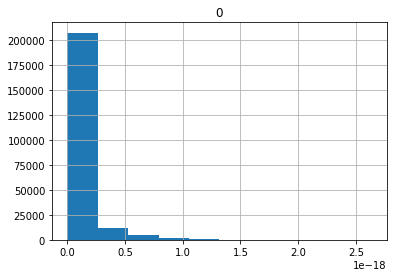

In [51]:
scores = pd.DataFrame(np.exp(GMM.score_samples(inlier_train)))
scores.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a20e17ac8>]],
      dtype=object)

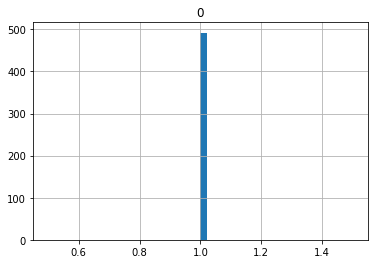

In [50]:
outlier_probs = pd.DataFrame(GMM.predict_proba(outliers))
outlier_probs.hist(bins=50)

## Gridsearch to get better density estimation...

In [ ]:
%%time
lowest_bic = np.infty
bic = []
n_components_range = range(1, 10)
cv_types = ['full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(inlier_train)
        bic.append(gmm.bic(inlier_train))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

In [ ]:
best_gmm

In [ ]:
bics = pd.DataFrame(bic)
bics.plot(kind="bar")

In [29]:
%%time
best_gmm = GaussianMixture(n_components=7, covariance_type="full", max_iter=200, n_init=5)
best_gmm.fit(inlier_train)

CPU times: user 40.8 s, sys: 2.1 s, total: 42.9 s
Wall time: 11 s


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [30]:
print("Training Likelihood: {:.3f}".format(best_gmm.score(inlier_train)))
print("Testing Likelihood: {:.3f}".format(best_gmm.score(inlier_test)))
print("Outlier Likelihood: {:.3f}".format(best_gmm.score(outliers)))

Training Likelihood: -6.333
Testing Likelihood: -6.734
Outlier Likelihood: -1560.566


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a222e3e48>,
      dtype=object)

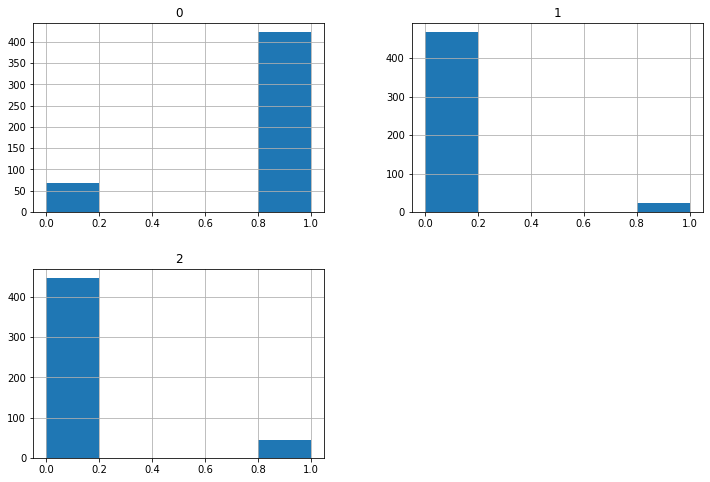

In [53]:
outlier_probs = pd.DataFrame(best_gmm.predict_proba(outliers))
outlier_probs.hist(bins=5, figsize=(12,8))

In [31]:
print("Testing Likelihood: {:.3f}".format(best_gmm.score(X_test)))

Testing Likelihood: -9.407


## Recall that score samples returns probability *densities*
> In order to use them we have to integrate from 0 to x

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a29df0748>]],
      dtype=object)

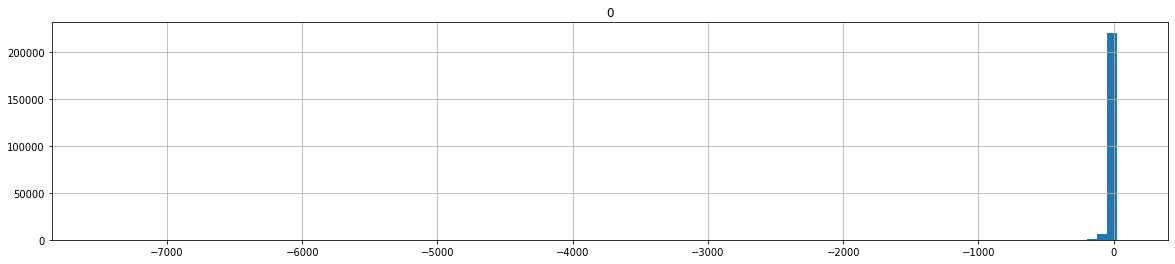

In [32]:
train_scores = pd.DataFrame(best_gmm.score_samples(inlier_train))
train_scores.hist(bins=100, figsize=(20,4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a273cf9b0>]],
      dtype=object)

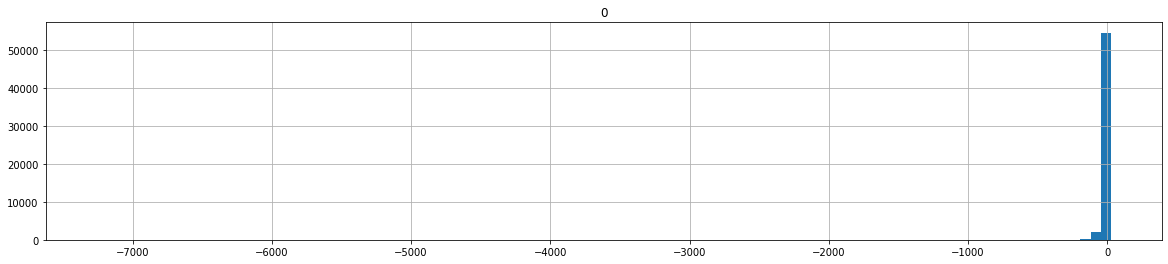

In [33]:
test_scores = pd.DataFrame(best_gmm.score_samples(X_test))
test_scores.hist(bins=100, figsize=(20,4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2991a5f8>]],
      dtype=object)

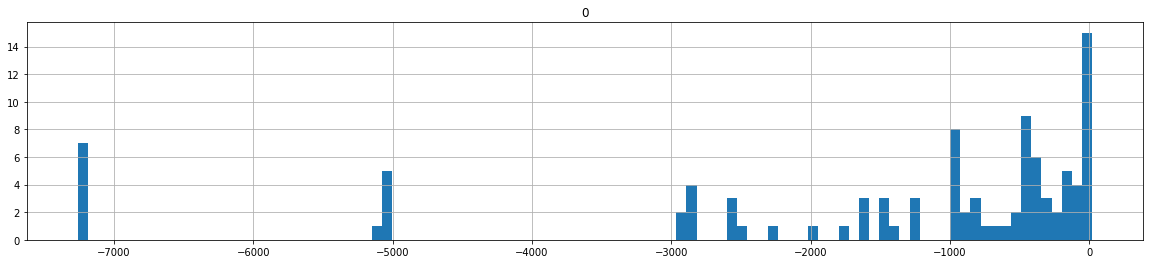

In [34]:
outlier_scores = pd.DataFrame(best_gmm.score_samples(outliers))
outlier_scores.hist(bins=100, figsize=(20,4))

In [35]:
test_scores.mean()

0   -9.406801
dtype: float64

In [39]:
test_scores.quantile(0.01)

0   -85.622239
Name: 0.01, dtype: float64

In [41]:
from sklearn.metrics import classification_report as report

thresh = test_scores.quantile(0.01)[0]
y_probs = np.concatenate((test_scores, outlier_scores))
y_true = np.concatenate(([0]*len(test_scores), [1]*len(outlier_scores)))
y_pred = y_probs < thresh
print(report(y_true, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.99973   0.98999   0.99484     56962
           1    0.12711   0.84694   0.22104        98

    accuracy                        0.98975     57060
   macro avg    0.56342   0.91847   0.60794     57060
weighted avg    0.99824   0.98975   0.99351     57060



In [ ]:
## Getting Precision Recall Curves

credit_prec, credit_recall, threshes = precision_recall_curve(y_true, y_probs)

plt.figure(figsize=(16, 8))
plt.plot(http_recall, http_prec, marker='.', label='GMM')

In [64]:
print(y_pred.shape)
y_true.shape

(4414, 1)


(984,)

In [66]:
y_probs.shape

(984, 1)

## Using Average Precision to test different thresholds

In [129]:
# thresh = inlier_test.mean() + inlier_test.std()*3
y_score = np.concatenate((test_scores, outlier_scores))
y_true = np.concatenate(([0]*len(test_scores), [1]*len(outlier_scores)))

average_precision_score(y_true, y_score)

0.3137928530365953

# HTTP Dataset

In [2]:
raw_data = pd.read_csv("data/http.csv", header=None)
raw_data.head()

,0,1,2,3
0,-2.302585,5.371103,10.716107,0
1,-2.302585,5.088213,8.418058,0
2,-2.302585,5.464255,7.113224,0
3,-2.302585,5.451468,7.616825,0
4,-2.302585,5.476882,6.186414,0


In [3]:
X = raw_data.drop(columns=[3])
y = raw_data[3].copy()

inliers = X[y==0]
outliers = X[y==1]
outlier_ratio = len(outliers) / len(X)

# Test samples of non-anomalous class are the same size as outliers
test_ratio = outlier_ratio
splitter = ShuffleSplit(n_splits=1, test_size=test_ratio)

for train_index,test_index in splitter.split(inliers):
    inlier_train = inliers.iloc[train_index]
    inlier_test = inliers.iloc[test_index]

# scaler = StandardScaler()

# inlier_train = scaler.fit_transform(inlier_train)
# inlier_test = scaler.transform(inlier_test)
# outliers = scaler.transform(outliers)

## Gridsearch to get better density estimation...

In [45]:
%%time
lowest_bic = np.infty
bic = []
n_components_range = range(1, 10)
cv_types = ['full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(inlier_train)
        bic.append(gmm.bic(inlier_train))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

CPU times: user 15min 25s, sys: 43.2 s, total: 16min 9s
Wall time: 4min 8s


In [ ]:
# n_components_range = range(1,8)
# param_grid = {'n_components': n_components_range}
# cv_test= KFold(n_splits=10)
# # class_weight='balanced' makes the result worse
# grid_search = GridSearchCV(GaussianMixture(n_init=3), param_grid, cv=cv_test, 
#                            scoring='average_precision', n_jobs=4)

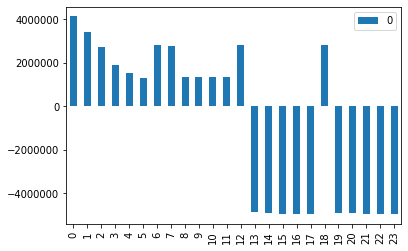

In [14]:
bics = pd.DataFrame(bic)
bics.plot(kind="bar")

In [6]:
%%time
best_gmm = GaussianMixture(n_components=3, covariance_type="full")
best_gmm.fit(inlier_train)

CPU times: user 6.17 s, sys: 250 ms, total: 6.42 s
Wall time: 1.68 s


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [7]:
print("Training Likelihood: {:.3f}".format(best_gmm.score(inlier_train)))
print("Testing Likelihood: {:.3f}".format(best_gmm.score(inlier_test)))
print("Outlier Likelihood: {:.3f}".format(best_gmm.score(outliers)))

Training Likelihood: 4.374
Testing Likelihood: 4.399
Outlier Likelihood: -23.864


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1b10c710>,
      dtype=object)

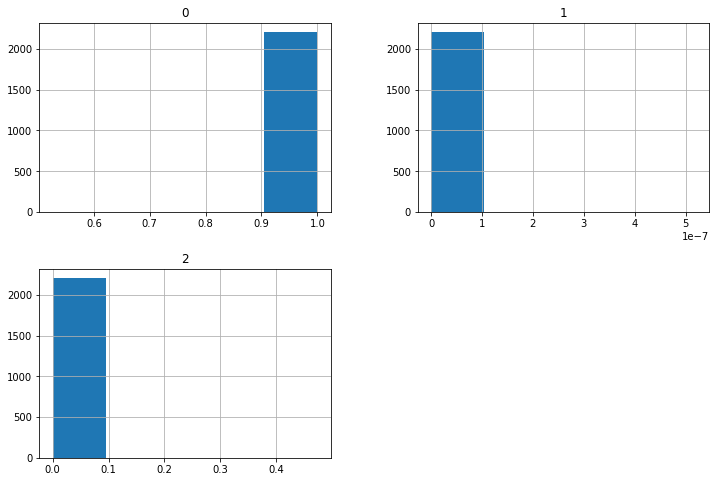

In [8]:
outlier_probs = pd.DataFrame(best_gmm.predict_proba(outliers))
outlier_probs.hist(bins=5, figsize=(12,8))

## Recall that score samples returns probability *densities*
> In order to use them we have to integrate from 0 to x

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1b0981d0>]],
      dtype=object)

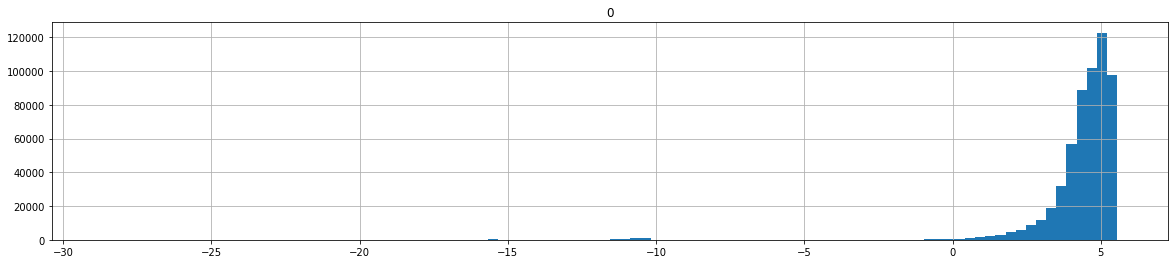

In [9]:
train_scores = pd.DataFrame(best_gmm.score_samples(inlier_train))
train_scores.hist(bins=100, figsize=(20,4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1a260198>]],
      dtype=object)

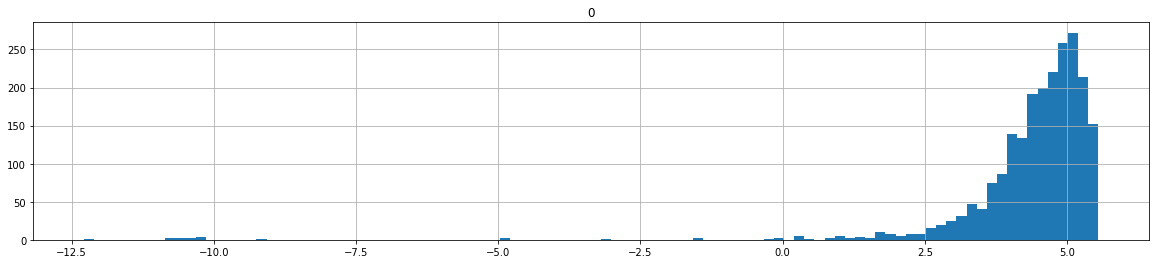

In [10]:
test_scores = pd.DataFrame(best_gmm.score_samples(inlier_test))
test_scores.hist(bins=100, figsize=(20,4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1fd35ef0>]],
      dtype=object)

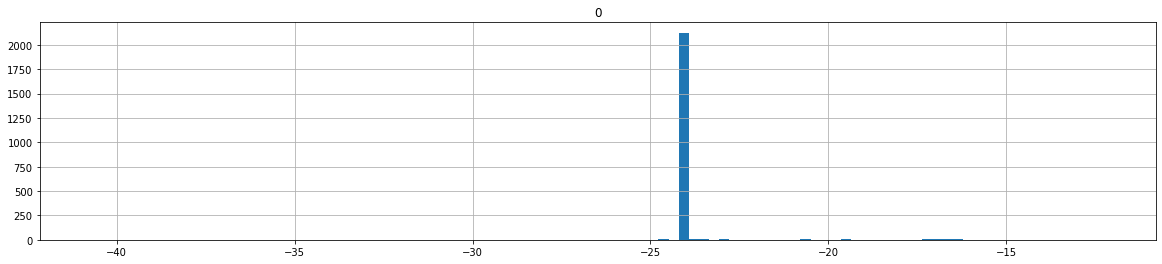

In [11]:
epsilon = 1e-10
outlier_scores = pd.DataFrame(best_gmm.score_samples(outliers))
outlier_scores.hist(bins=100, figsize=(20,4))

## Using Average Precision to test different thresholds

In [45]:
len(outlier_scores)

2211

In [26]:
# thresh = inlier_test.mean() + inlier_test.std()*3
test_data = np.concatenate([inlier_test, outliers])
y_probs = np.concatenate((test_scores, outlier_scores))

y_true = np.concatenate(([0]*len(test_scores), [1]*len(outlier_scores)))

average_precision_score(y_true, y_probs)

0.4781972811289943

In [46]:
from sklearn.metrics import classification_report as report

thresh = -12
y_pred = y_probs < thresh
print(report(y_true, y_pred,digits=5))

              precision    recall  f1-score   support

           0    1.00000   0.99955   0.99977      2203
           1    0.99955   1.00000   0.99977      2211

    accuracy                        0.99977      4414
   macro avg    0.99977   0.99977   0.99977      4414
weighted avg    0.99977   0.99977   0.99977      4414



In [40]:
np.int(y_probs < -12)

TypeError: only size-1 arrays can be converted to Python scalars

In [13]:
average_precision_score([1]*len(outlier_scores), outlier_scores)

0.9999999999999999

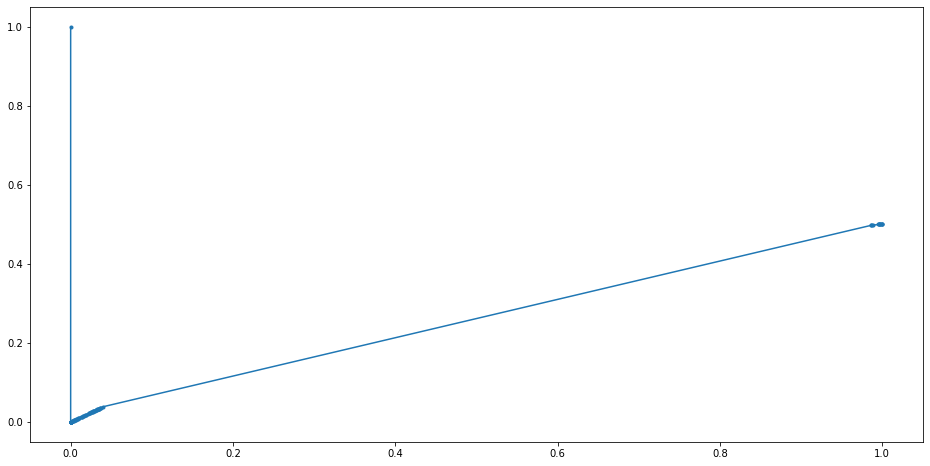

In [33]:
## Getting Precision Recall Curves

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support
# from sklearn.metrics import plot_precision_recall_curve

http_prec, http_recall, threshes = precision_recall_curve(y_true, y_probs)

plt.figure(figsize=(16, 8))
plt.plot(http_recall, http_prec, marker='.', label='GMM')

In [34]:
threshes

array([-40.73992942, -25.03706111, -24.58645017, ...,   5.55191258,
         5.55216606,   5.55324887])

In [27]:
# plot_precision_recall_curve(best_gmm, test_data, y_true)

NameError: name 'plot_precision_recall_curve' is not defined